# **GROUP PROJECT: OBESITY LEVEL CLASSIFICATION**   

---

**COURSE DETAILS:**   
- UNIVERSITI TEKNOLOGI MALAYSIA (UTM)  
- FACULTY OF COMPUTING  
- SECB3203: PROGRAMMING FOR BIOINFORMATICS   
- SECTION 02   
- DR. SEAH CHOON SEN (LECTURER)   
- GROUP 07   

**GROUP MEMBER DETAILS:**
| Name    | Matric Number |
| -------- | ------- |
| MUHAMMAD FARIHIN BIN SALEH             | A25CS0102 |
| MUHAMMAD MIRZA HASIF BIN MOHD FAHMI    | A25CS0108 |
| MUHAMMAD NAWFAL BIN MOHD SHAIFUDDIN    | A25CS0109 |

**DESCRIPTION:**   
Full Coding for Obesity Level Classification project.

---

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Settings
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

In [14]:
# PART 1: DATA WRANGLING
print("--- LOADING & CLEANING DATA ---")
df = pd.read_csv('C:\\Python\\ObesityDataSet_raw_and_data_sinthetic.csv')

# 1. Handling Missing Values
df = df.dropna()

# 2. Rename Columns (Full English Names for Clarity)
df.rename(columns={
    'FAVC': 'HighCaloricFood',
    'FCVC': 'VegConsumption',       
    'NCP': 'MealsPerDay',           
    'CAEC': 'SnackFood',            
    'CH2O': 'WaterIntake',          
    'SCC': 'MonitorCalories',       
    'FAF': 'PhysicalActivity',      
    'TUE': 'TechUseTime',           
    'CALC': 'Alcohol',              
    'MTRANS': 'Transportation',     
    'NObeyesdad': 'ObesityLevel'
}, inplace=True)

# 3. Binning 
# Binning Physical Activity
bins_faf = [-1, 0.9, 1.9, 3.0]
labels_faf = ['Sedentary', 'Moderate', 'Active']
df['Activity_Level'] = pd.cut(df['PhysicalActivity'], bins=bins_faf, labels=labels_faf)

# Binning Technology Usage
bins_tue = [-1, 0.9, 3.0]
labels_tue = ['Low_Tech_Use', 'High_Tech_Use']
df['Tech_Usage'] = pd.cut(df['TechUseTime'], bins=bins_tue, labels=labels_tue)

print(f"Data Loaded: {df.shape}")
print(df.head())

--- LOADING & CLEANING DATA ---
Data Loaded: (2111, 19)
    Age  Gender  Height  Weight     Alcohol HighCaloricFood  VegConsumption  \
0  21.0  Female    1.62    64.0          no              no             2.0   
1  21.0  Female    1.52    56.0   Sometimes              no             3.0   
2  23.0    Male    1.80    77.0  Frequently              no             2.0   
3  27.0    Male    1.80    87.0  Frequently              no             3.0   
4  22.0    Male    1.78    89.8   Sometimes              no             2.0   

   MealsPerDay MonitorCalories SMOKE  WaterIntake  \
0          3.0              no    no          2.0   
1          3.0             yes   yes          3.0   
2          3.0              no    no          2.0   
3          3.0              no    no          2.0   
4          1.0              no    no          2.0   

  family_history_with_overweight  PhysicalActivity  TechUseTime  SnackFood  \
0                            yes               0.0          1.0  Sometim


--- RUNNING EDA ---
Descriptive Statistics:
           Age   Height   Weight  VegConsumption  WaterIntake  \
count  2111.00  2111.00  2111.00         2111.00      2111.00   
mean     24.31     1.70    86.59            2.42         2.01   
std       6.35     0.09    26.19            0.53         0.61   
min      14.00     1.45    39.00            1.00         1.00   
25%      19.95     1.63    65.47            2.00         1.58   
50%      22.78     1.70    83.00            2.39         2.00   
75%      26.00     1.77   107.43            3.00         2.48   
max      61.00     1.98   173.00            3.00         3.00   

       PhysicalActivity  
count           2111.00  
mean               1.01  
std                0.85  
min                0.00  
25%                0.12  
50%                1.00  
75%                1.67  
max                3.00  

Grouping Analysis:
Average Weight based on High Caloric Food Consumption:
HighCaloricFood
no     66.908408
yes    89.169672
Name: Weig

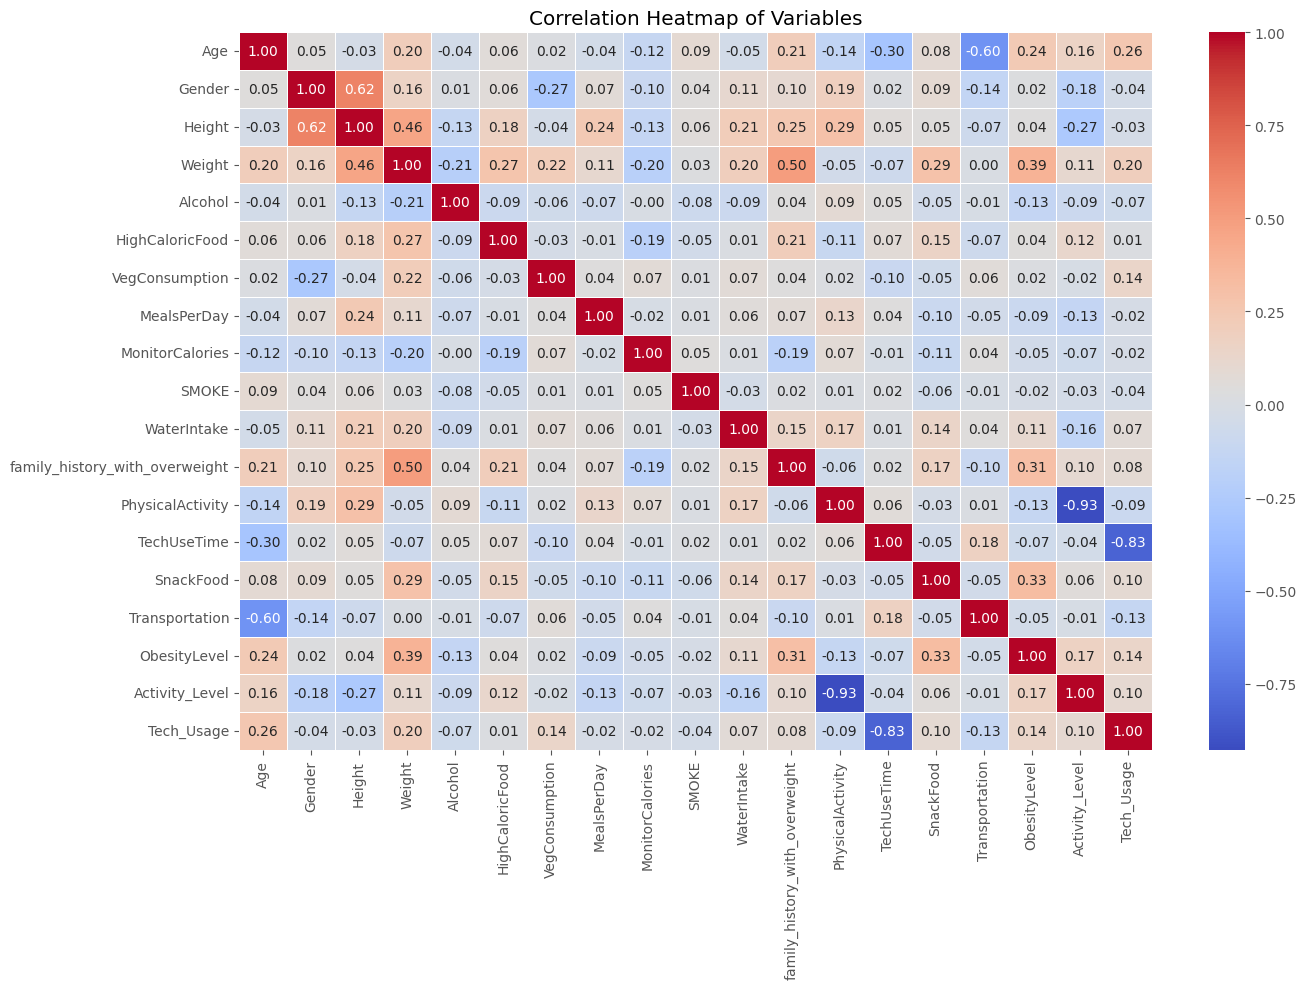

In [15]:
# PART 2: EXPLORATORY DATA ANALYSIS (EDA)
print("\n--- RUNNING EDA ---")

# 1. Descriptive Statistics
desc_stats = df[['Age', 'Height', 'Weight', 'VegConsumption', 'WaterIntake', 'PhysicalActivity']].describe().round(2)
print("Descriptive Statistics:")
print(desc_stats)

# 2. GROUPING ANALYSIS
# Question: Does eating high caloric food (Yes/No) affect average weight?
group_stat = df.groupby('HighCaloricFood')['Weight'].mean()
print("\nGrouping Analysis:")
print("Average Weight based on High Caloric Food Consumption:")
print(group_stat)

# 3. ANOVA Testing (Hypothesis Testing)
# TEST 1: Does 'Transportation' (Car vs Walk vs Bus) significantly change 'Weight'?
groups = [df[df['Transportation'] == t]['Weight'] for t in df['Transportation'].unique()]
f_val, p_val = stats.f_oneway(*groups)

print("\nANOVA Tests:")
print(f"1. Test: Transportation vs Weight")
print(f"   F-Value: {f_val:.2f}")
print(f"   P-Value: {p_val:.5e}")

if p_val < 0.05:
    print("   >> RESULT: Statistically Significant (Transportation affects Weight).")
else:
    print("   >> RESULT: Not Significant.")

# TEST 2: Snacking Habits (SnackFood) vs Weight
groups_caec = [df[df['SnackFood'] == t]['Weight'] for t in df['SnackFood'].unique()]
f_val_caec, p_val_caec = stats.f_oneway(*groups_caec)

print(f"\n2. Test: Snacking Habits (SnackFood) vs Weight")
print(f"   F-Value: {f_val_caec:.2f}")
print(f"   P-Value: {p_val_caec:.5e}")

if p_val_caec < 0.05:
    print("   >> RESULT: Significant! Snacking frequency affects Weight.")
else:
    print("   >> RESULT: Not Significant.")

# TEST 3: Alcohol Consumption (Alcohol) vs Weight
groups_calc = [df[df['Alcohol'] == t]['Weight'] for t in df['Alcohol'].unique()]
f_val_calc, p_val_calc = stats.f_oneway(*groups_calc)

print(f"\n3. Test: Alcohol Consumption vs Weight")
print(f"   F-Value: {f_val_calc:.2f}")
print(f"   P-Value: {p_val_calc:.5e}")

if p_val_calc < 0.05:
    print("   >> RESULT: Significant! Alcohol consumption affects Weight.")
else:
    print("   >> RESULT: Not Significant.")

# 4. Correlation Heatmap
# Encode temporarily for the heatmap
df_encoded_eda = df.copy()
le_eda = LabelEncoder()
for col in df_encoded_eda.select_dtypes(include=['object', 'category']).columns:
    df_encoded_eda[col] = le_eda.fit_transform(df_encoded_eda[col].astype(str))

plt.figure(figsize=(14, 10))
numeric_df = df_encoded_eda.select_dtypes(include=['number'])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Variables')
plt.tight_layout()
plt.show()

In [16]:
# PART 3: PREPROCESSING FOR MODELING
print("\n--- PREPROCESSING ---")

# 1. Encode Target Variable
le_target = LabelEncoder()
df['ObesityLevel_Encoded'] = le_target.fit_transform(df['ObesityLevel'])

# 2. Encode Categorical Features
le_features = LabelEncoder()
# Exclude the Target and the Binned columns if you don't want to use them (optional)
# Here we encode all object/category columns
cat_cols = df.select_dtypes(include=['object', 'category']).columns
for col in cat_cols:
    if col != 'ObesityLevel': # Skip raw target text
        df[col] = le_features.fit_transform(df[col].astype(str))

# 3. Split Data
X = df.drop(['ObesityLevel', 'ObesityLevel_Encoded'], axis=1)
y = df['ObesityLevel_Encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Scaling (Standardization)
# Fit on Train, Transform on Test to prevent leakage
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# Keep column names for later visualizations
feature_names = X.columns 

print("Data Split & Scaled.")


--- PREPROCESSING ---
Data Split & Scaled.



--- TRAINING BASELINE MODELS ---
Random Forest Accuracy: 94.7991%
XGBoost Accuracy: 95.5083%
SVM Accuracy: 83.6879%
Logistic Regression Accuracy: 72.8132%


C:\Users\farih\AppData\Local\Temp\ipykernel_22240\3262252437.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Model', data=results_df, palette='viridis')


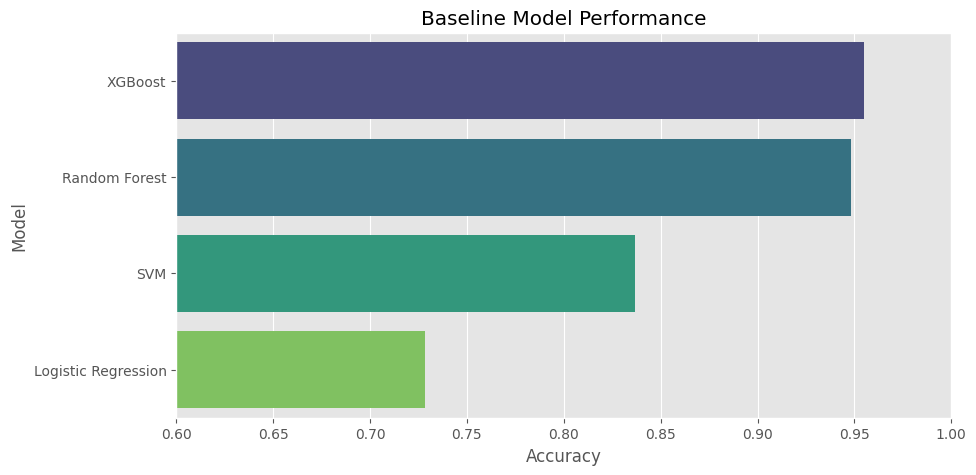

In [17]:
# PART 4: MODEL DEVELOPMENT
print("\n--- TRAINING BASELINE MODELS ---")

models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='mlogloss', random_state=42),
    "SVM": SVC(kernel='linear', probability=True, random_state=42), # probability=True for Log Loss check later
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42)
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results.append({'Model': name, 'Accuracy': acc})
    print(f"{name} Accuracy: {acc:.4%}")

# Quick Visualization of Baseline
results_df = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False)
plt.figure(figsize=(10, 5))
sns.barplot(x='Accuracy', y='Model', data=results_df, palette='viridis')
plt.title('Baseline Model Performance')
plt.xlim(0.6, 1.0)
plt.show()



--- EVALUATING BEST MODEL: XGBoost ---


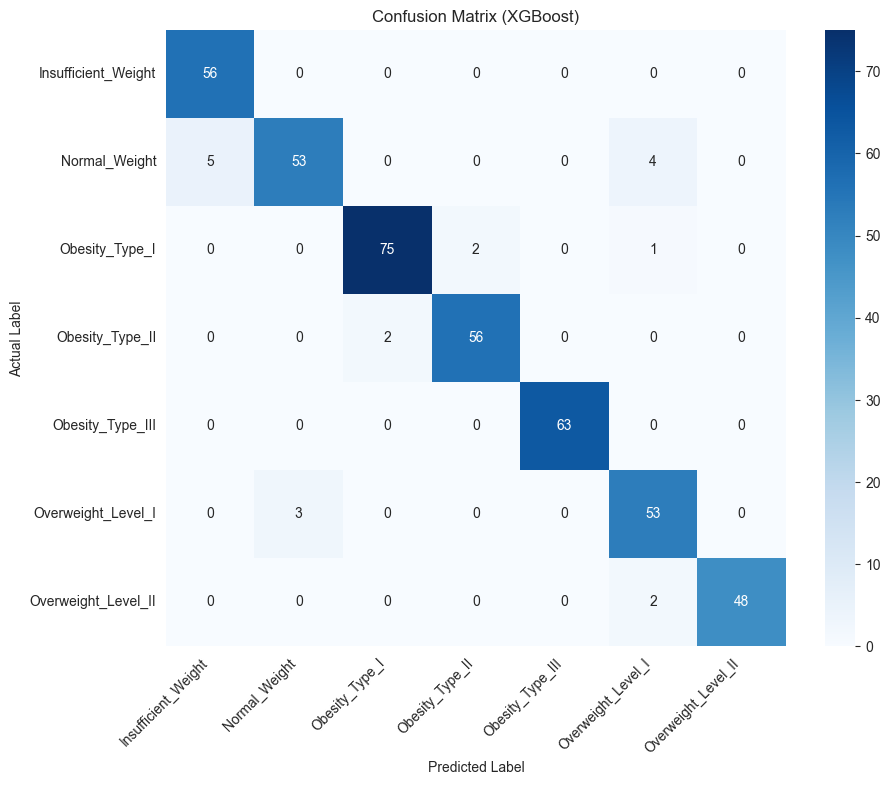

Classification Report for XGBoost:
                     precision    recall  f1-score   support

Insufficient_Weight   0.918033  1.000000  0.957265        56
      Normal_Weight   0.946429  0.854839  0.898305        62
     Obesity_Type_I   0.974026  0.961538  0.967742        78
    Obesity_Type_II   0.965517  0.965517  0.965517        58
   Obesity_Type_III   1.000000  1.000000  1.000000        63
 Overweight_Level_I   0.883333  0.946429  0.913793        56
Overweight_Level_II   1.000000  0.960000  0.979592        50

           accuracy                       0.955083       423
          macro avg   0.955334  0.955475  0.954602       423
       weighted avg   0.956334  0.955083  0.954935       423

Generating Learning Curve...


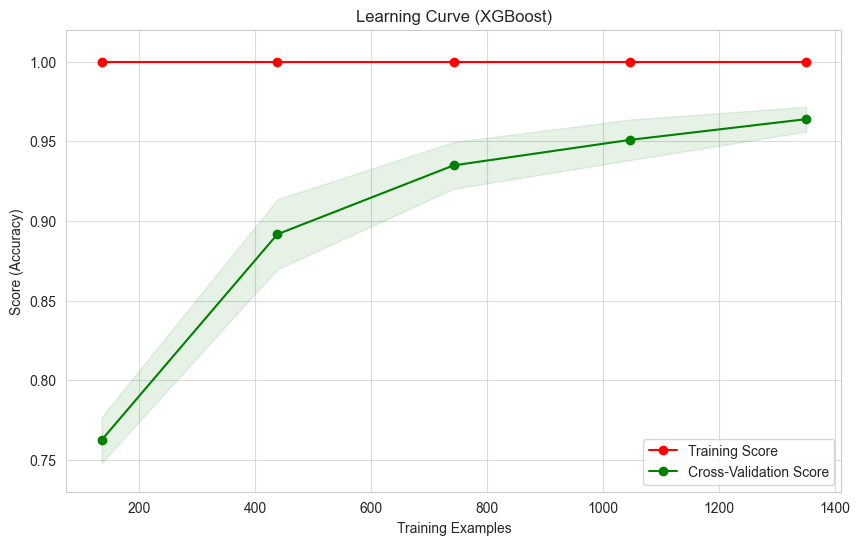


--- Ridge Regression Stability Check ---
Ridge Test Accuracy: 63.12%
Ridge CV Mean Accuracy: 62.56%
>> DIAGNOSIS: Model is STABLE (Low Variance).


In [23]:
# PART 5: DEEP DIVE EVALUATION (Best Model)
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')
sns.set_style("whitegrid") 

best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name] # Likely XGBoost
print(f"\n--- EVALUATING BEST MODEL: {best_model_name} ---")

# 1. Confusion Matrix
y_pred_best = best_model.predict(X_test)
class_names = le_target.classes_

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix ({best_model_name})')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

# 2. Classification Report
print(f"Classification Report for {best_model_name}:")
print(classification_report(y_test, y_pred_best, target_names=class_names, digits=6))

# 3. OVERFITTING CHECK: Learning Curve
def plot_learning_curve(estimator, title, X, y, cv=5):

    plt.figure(figsize=(10, 6), facecolor='white')
    plt.title(title)
    plt.xlabel("Training Examples")
    plt.ylabel("Score (Accuracy)")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5)
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Add a grid to the plot
    plt.grid(True, linestyle='-', alpha=0.7)

    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")

    plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training Score")
    plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-Validation Score")

    plt.legend(loc="best")
    # Set the y-axis limit to match the example
    plt.ylim(0.73, 1.02)
    plt.show()

print("Generating Learning Curve...")
plot_learning_curve(best_model, f"Learning Curve ({best_model_name})", X_train, y_train)


# 4. RIDGE REGRESSION (Linear Baseline)
print("\n--- Ridge Regression Stability Check ---")
ridge_model = RidgeClassifier(alpha=1.0) 
ridge_model.fit(X_train, y_train)

# Test vs CV
y_pred_ridge = ridge_model.predict(X_test)
test_acc = accuracy_score(y_test, y_pred_ridge)
cv_scores = cross_val_score(ridge_model, X_train, y_train, cv=10)

print(f"Ridge Test Accuracy: {test_acc:.2%}")
print(f"Ridge CV Mean Accuracy: {cv_scores.mean():.2%}")

if abs(test_acc - cv_scores.mean()) < 0.05:
    print(">> DIAGNOSIS: Model is STABLE (Low Variance).")
else:
    print(">> DIAGNOSIS: Model shows signs of instability.")

In [24]:
# PART 6: OPTIMIZATION (GRID SEARCH)
print("\n--- STARTING GRID SEARCH (XGBoost) ---")

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 10],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0]
}

xgb_base = XGBClassifier(eval_metric='mlogloss', random_state=42)
grid = GridSearchCV(xgb_base, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

best_xgb = grid.best_estimator_
print(f"Best Params: {grid.best_params_}")
print(f"Best Training Score: {grid.best_score_:.4%}")

# MODEL REFINEMENT
print("\n--- Final Evaluation of Optimized Model ---")

# 1. Extract the Best Model from the Grid Search
best_xgb = grid.best_estimator_

# 2. Predict on the Test Set (The Final Exam)
y_pred_refined = best_xgb.predict(X_test)

# 3. Generate the Final Classification Report
# We recover the original class names (e.g., 'Obesity_Type_I') for readability
target_names = le_target.inverse_transform(np.unique(y_test))

print(f"Optimized Model Performance on Test Data:")
print(classification_report(y_test, y_pred_refined, target_names=target_names, digits=6))

# Check to see improvement
final_acc = accuracy_score(y_test, y_pred_refined)
print(f"Final Accuracy: {final_acc:.4%}")


--- STARTING GRID SEARCH (XGBoost) ---
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'subsample': 1.0}
Best Training Score: 96.2678%

--- Final Evaluation of Optimized Model ---
Optimized Model Performance on Test Data:
                     precision    recall  f1-score   support

Insufficient_Weight   0.933333  1.000000  0.965517        56
      Normal_Weight   0.946429  0.854839  0.898305        62
     Obesity_Type_I   0.974026  0.961538  0.967742        78
    Obesity_Type_II   0.965517  0.965517  0.965517        58
   Obesity_Type_III   1.000000  1.000000  1.000000        63
 Overweight_Level_I   0.868852  0.946429  0.905983        56
Overweight_Level_II   1.000000  0.960000  0.979592        50

           accuracy                       0.955083       423
          macro avg   0.955451  0.955475  0.954665       423
       weighted avg   0.956442  0.955083  0.954994       423

Final Accuracy: 

C:\Users\farih\AppData\Local\Temp\ipykernel_22240\3531830752.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Accuracy', y='Model', data=final_df, palette=colors)


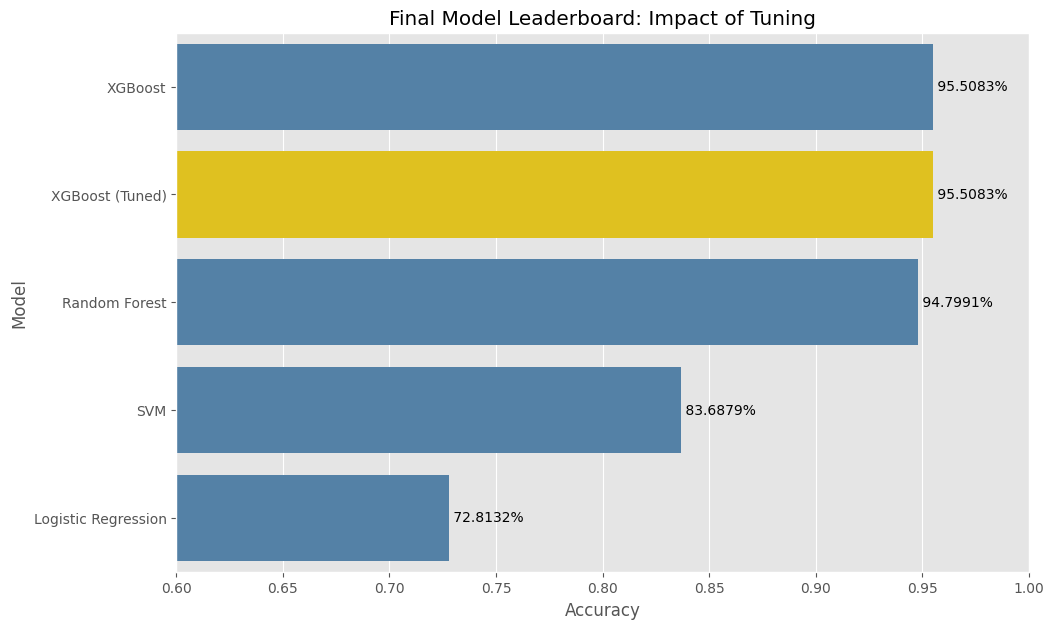

In [20]:
# PART 7: FINAL COMPARISON & INSIGHTS

# 1. Add Tuned Model to Results
y_pred_refined = best_xgb.predict(X_test)
final_acc = accuracy_score(y_test, y_pred_refined)

clean_results = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    clean_results.append({'Model': name, 'Accuracy': acc})

clean_results.append({'Model': 'XGBoost (Tuned)', 'Accuracy': final_acc})
final_df = pd.DataFrame(clean_results).sort_values(by='Accuracy', ascending=False)

# 2. Final Leaderboard Chart
plt.figure(figsize=(11, 7))
colors = ['gold' if 'Tuned' in x else 'steelblue' for x in final_df['Model']]
ax = sns.barplot(x='Accuracy', y='Model', data=final_df, palette=colors)
plt.xlim(0.6, 1.0)
plt.title('Final Model Leaderboard: Impact of Tuning')
for i, (index, row) in enumerate(final_df.iterrows()):
    ax.text(row.Accuracy, i, f' {row.Accuracy:.4%}', color='black', ha="left", va="center")
plt.show()